In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import timedelta 

sns.set()
sns.set_color_codes()
sns.set(rc={'text.usetex' : True}) 
sns.set_context('paper', font_scale=1.8) 
sns.set_style("whitegrid")

**We extract from the .csv file the time-series data containing the glycemia over time. We modify the data to work with the usual European unit for glycemia (mg/dL) and we resample it**

In [2]:
def import_clean_data(path):

    df = pd.read_csv(path, skiprows=1, 
                     usecols=['DateTimeFormatted','glucose'])
    
    df['date'] = df['DateTimeFormatted']
    df = df.set_index('date')
    
    df.index = pd.to_datetime(df.index)
    df['glucose'] = df['glucose']*18
    
    df = df.resample('5T').mean()
    
    df['time'] = df.index.hour + df.index.minute/60.
    df['glucose'] = df['glucose'].interpolate()

    return df

path = 'data/data_30062020.csv'
df = import_clean_data(path)

# Let's take a look at the cleaned data !
print(df.head(n=6))
print(' ')
print(df.tail(n=6))
print(' ')
print(df.shape)

                        glucose      time
date                                     
2019-08-13 03:05:00  267.600006  3.083333
2019-08-13 03:10:00  266.166672  3.166667
2019-08-13 03:15:00  264.733338  3.250000
2019-08-13 03:20:00  263.300004  3.333333
2019-08-13 03:25:00  261.866670  3.416667
2019-08-13 03:30:00  260.433336  3.500000
 
                        glucose       time
date                                      
2020-07-03 23:05:00  155.700000  23.083333
2020-07-03 23:10:00  159.300000  23.166667
2020-07-03 23:15:00  164.326153  23.250000
2020-07-03 23:20:00  169.352307  23.333333
2020-07-03 23:25:00  174.378460  23.416667
2020-07-03 23:30:00  179.404614  23.500000
 
(93846, 2)


**The following report shows the distribution of glycemia along the day aiming at identifying the out-of-range glycemia to trigger the insulin (or other medicine) treatment modifications**

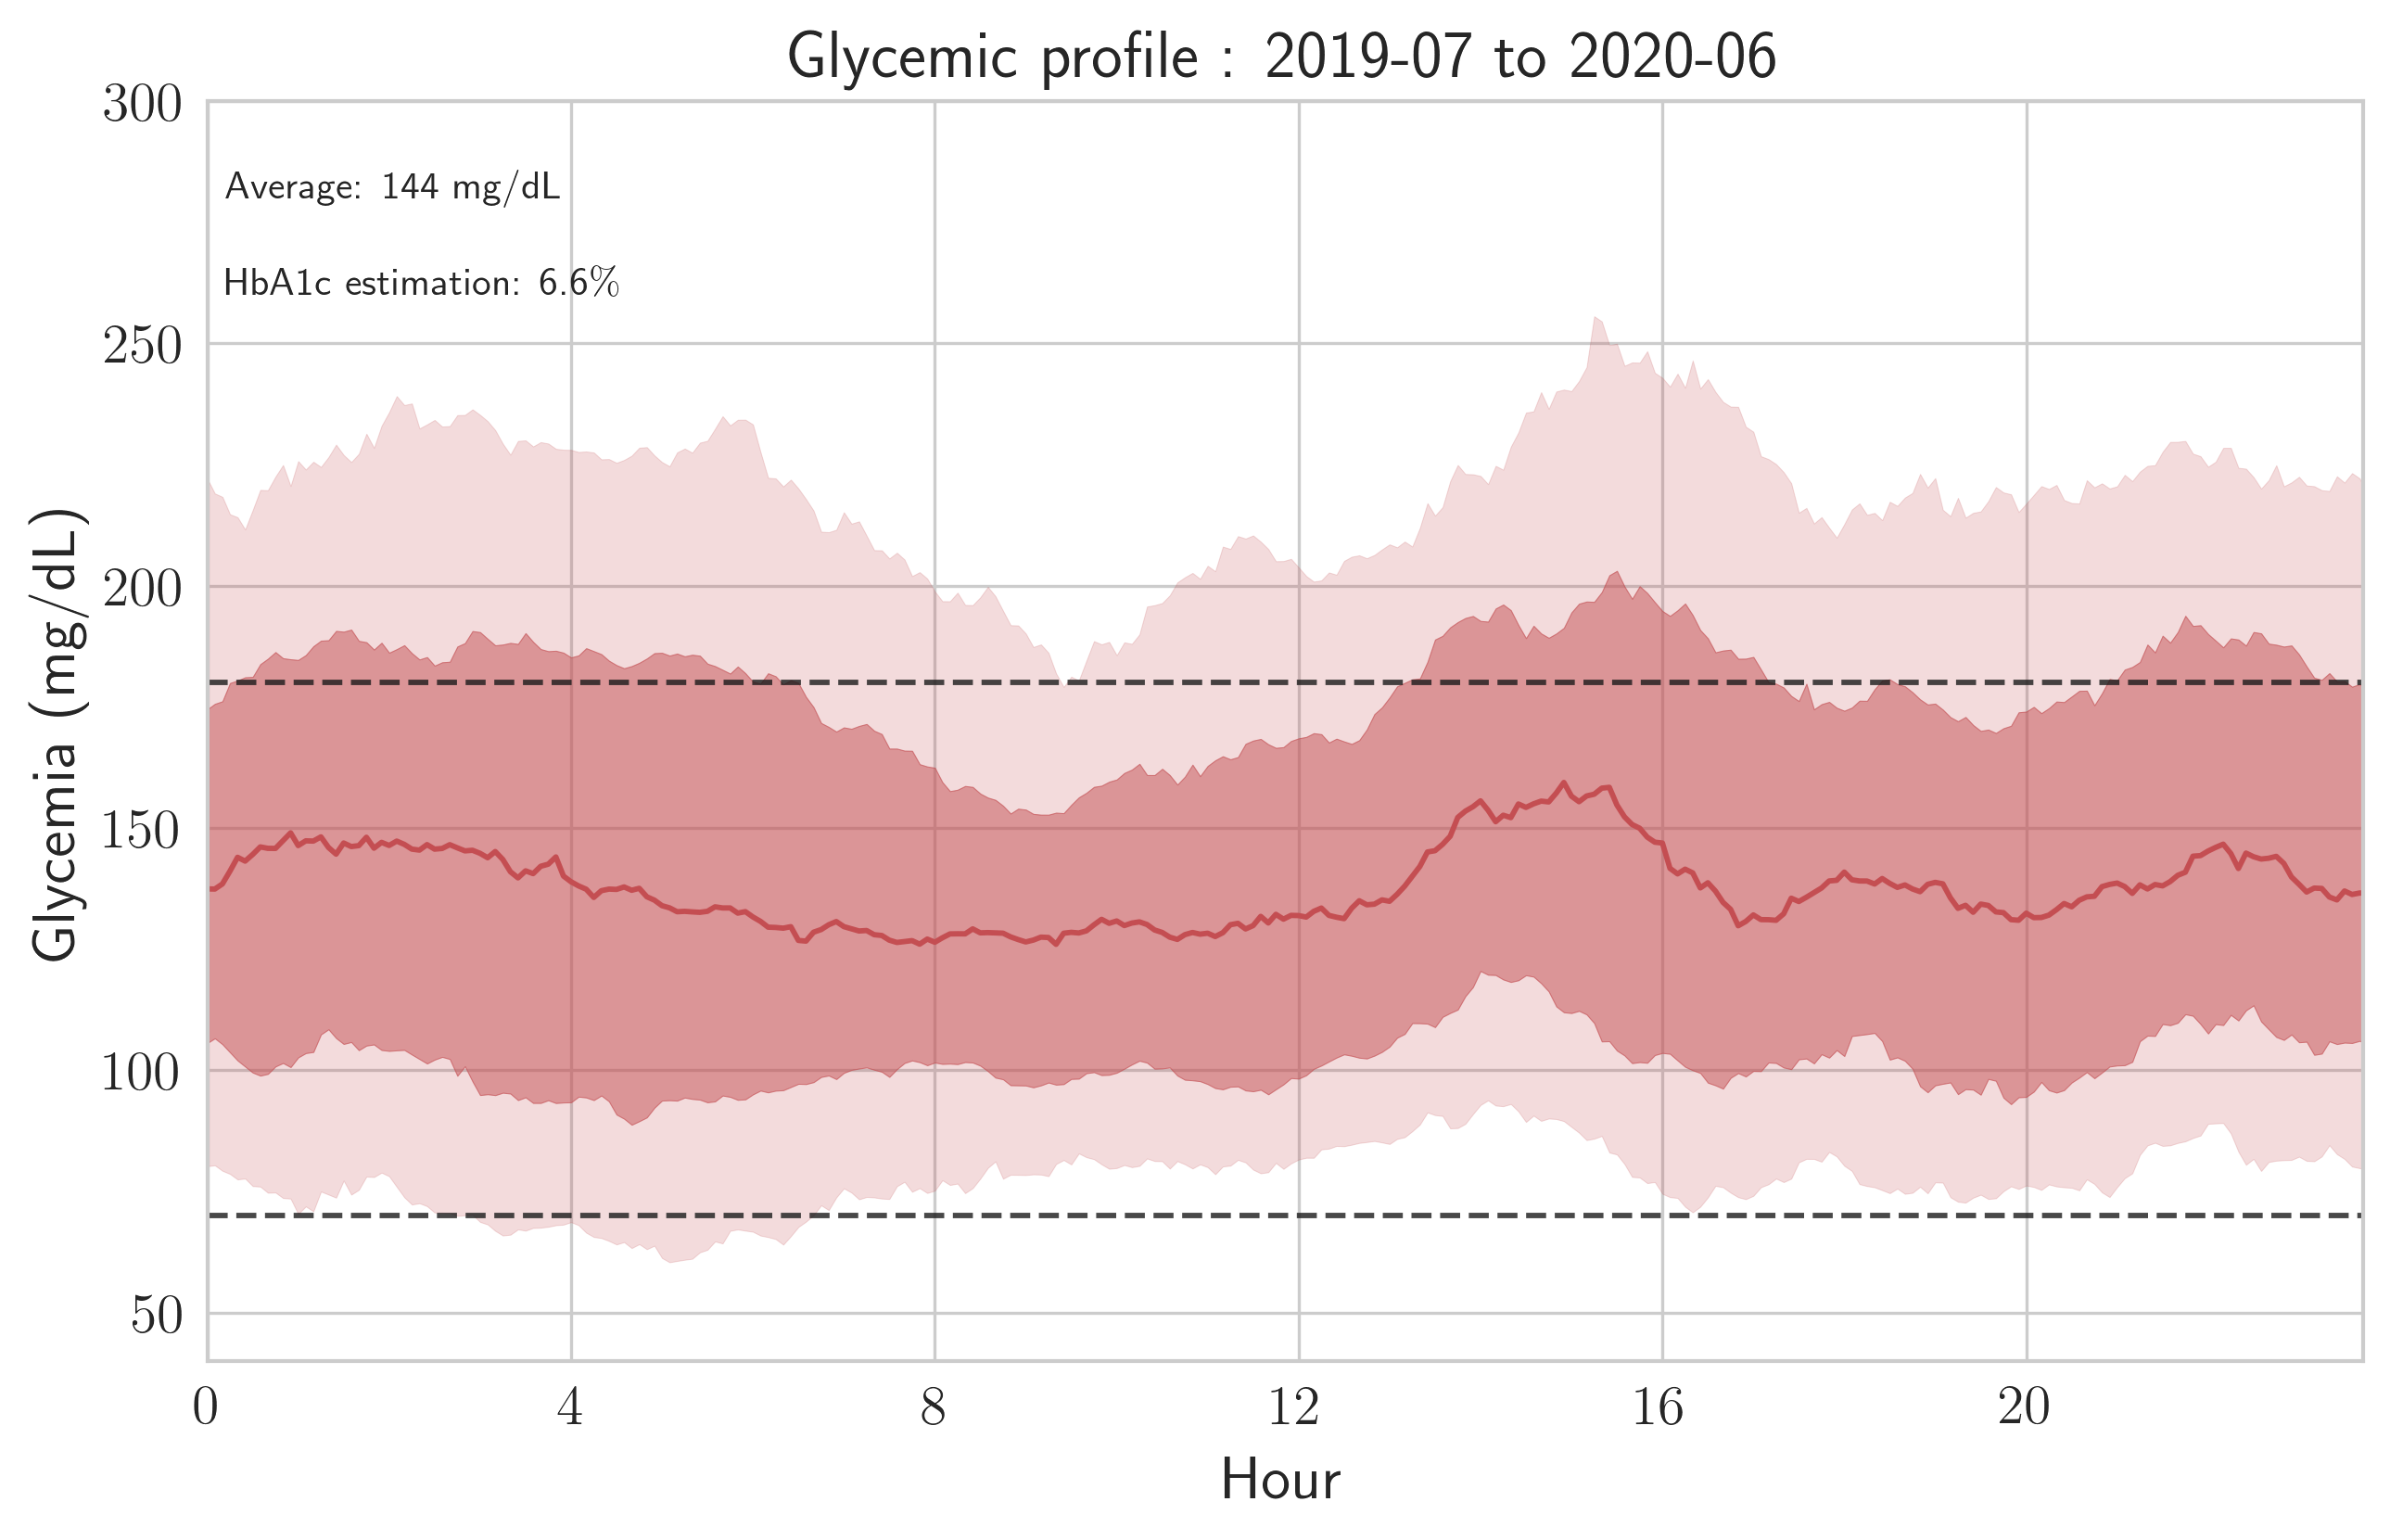

In [3]:
%matplotlib inline 

def profile_quantile(df, quants):
    """ 
    Inputs: 
        df - a dataframe with a column 'time'
        quants - a list of floats

    Output:
        result - a list of dataframes    
    """

    result = []
    for quant in quants:
        result.append(df.reset_index().groupby(['time']).\
                      quantile(quant).reset_index())
    return result

def plot_glycemic_profile24h(df, start_date, end_date):
    
    df = df[start_date:end_date]
    quants = [0.10, 0.25, 0.50, 0.75, 0.90]
    df_10, df_25, df_50, df_75, df_90 = profile_quantile(df, quants)

    fig, ax = plt.subplots(figsize=(10, 6),dpi=300)
    
    plt.plot(df_50['time'], df_50['glucose'], color='r')
    plt.fill_between(df_50['time'], df_10['glucose'], df_25['glucose'], 
                 color='r', alpha=0.2)
    plt.fill_between(df_50['time'], df_25['glucose'], df_75['glucose'], 
                 color='r', alpha=0.6)
    plt.fill_between(df_50['time'], df_75['glucose'], df_90['glucose'], 
                 color='r', alpha=0.2)

    ax.set_xlim(0, 23.7)
    ax.set_ylim(40, 300)
    ax.axhline(70, color='k', alpha=0.8, linestyle='--')
    ax.axhline(180, color='k', alpha=0.8, linestyle='--')
    ax.set_title(r'Glycemic profile : %s-%02d to %s-%02d'%(start_date.year,
                                                       start_date.month,
                                                       end_date.year,
                                                       end_date.month))
    ax.set_xlabel('Hour')
    ax.set_ylabel(r'Glycemia (mg/dL)')
    ax.set_xticks([0, 4, 8, 12, 16, 20])
    
    moyenne = df['glucose'].mean()
    hba1c = (moyenne+46.7) / 28.7
    
    plt.text(0.2, 280, 'Average: %3.0f mg/dL'%moyenne)
    plt.text(0.2, 260, r'HbA1c estimation: %1.1f'%hba1c+'$\%$')

end_date = pd.to_datetime('30-06-2020')

option = '1_year'

option_dict = {'14_days':[14, 4, 1],\
          '3_months':[90, 30, 15],\
          '1_year':[365, 90, 90]}

start_date = end_date - timedelta(days=option_dict[option][0])

plot_glycemic_profile24h(df, start_date, end_date)


**The following report shows the time in range (blue: below 70 mg/dL, green : between 70 and 180 mg/dL, orange : between 180 and 250 mg/dL, red : above 250 mg/dL). The target depends on the patient, but a common target is that at least 70% of the time is spent between 70 and 180 mg/dL, hence the dark line at 70%. Another common target is to limit to 10% the time spent below 70 mg/dL, hence the dark line at 90%**


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  im

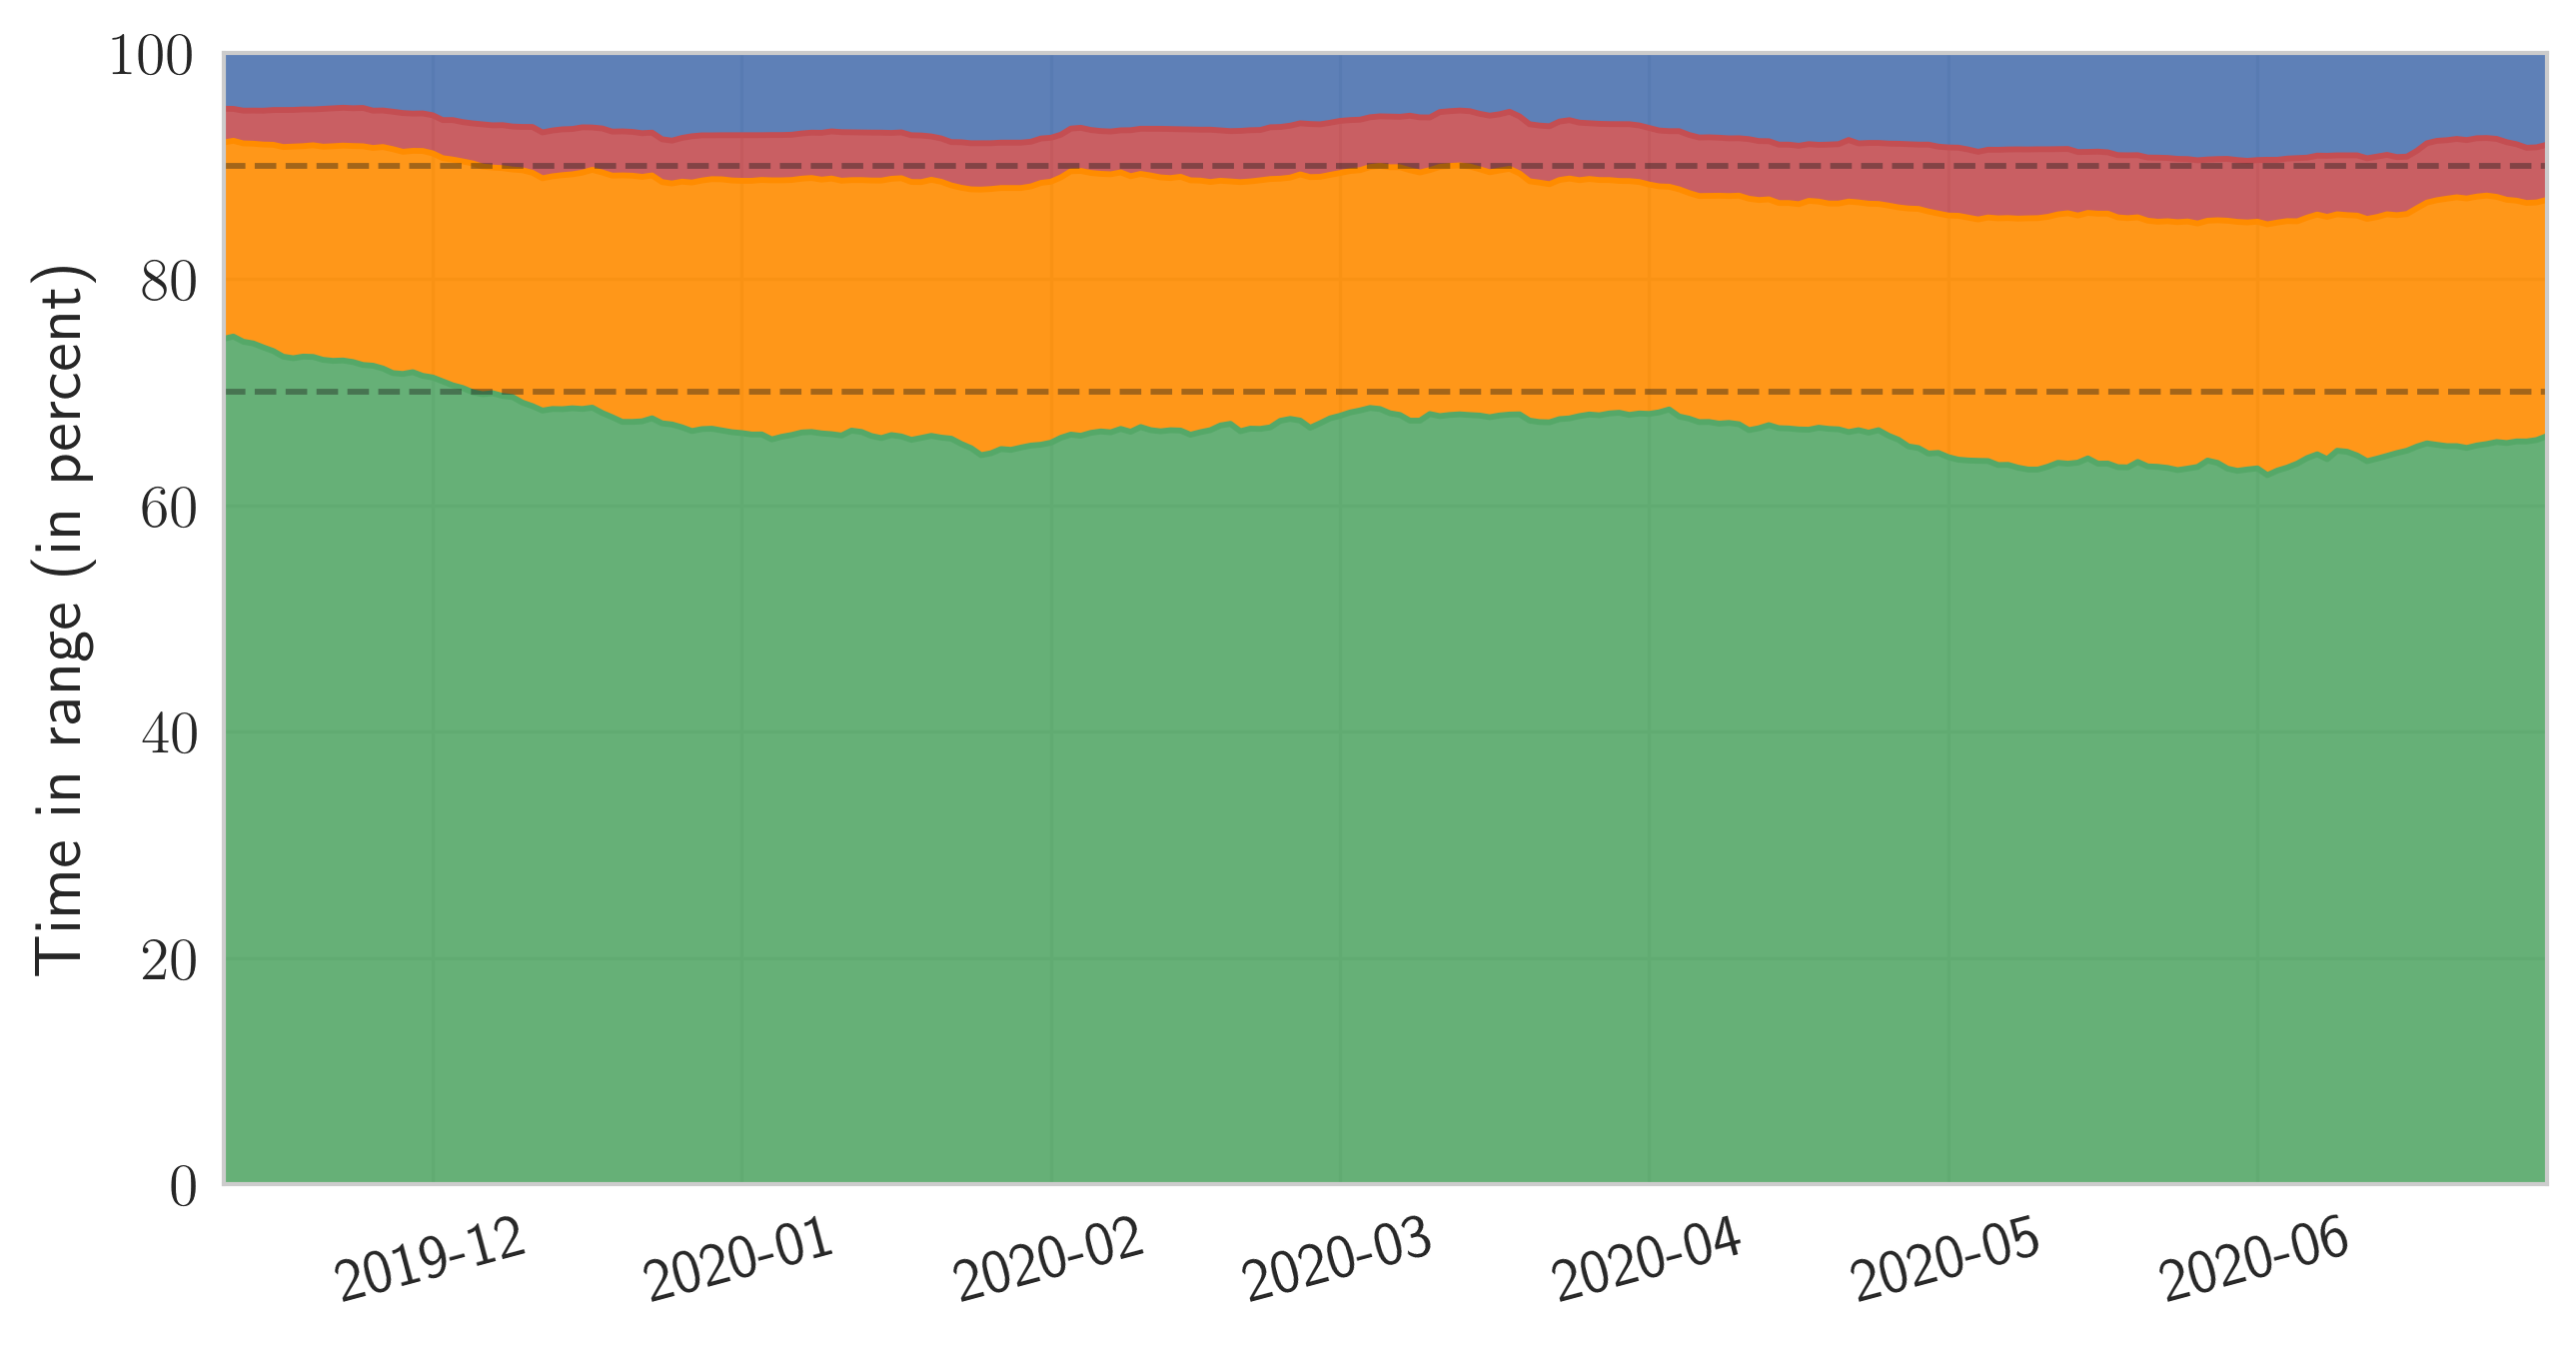

In [4]:
def plot_time_in_range(df, start_date, end_date, window_size):

    df = df[start_date:end_date]

    df['hypo'] = (df['glucose'] < 70)
    df['normal'] = (df['glucose'] > 70) & (df['glucose'] < 180)
    df['minihyper'] = (df['glucose'] > 180) & (df['glucose'] < 250)
    df['hyper'] = (df['glucose'] > 250)
    
    cols_to_keep = ['hypo', 'normal', 'minihyper', 'hyper']
    df = 100*df[cols_to_keep].groupby(df.index.date).mean()
    df = df.rolling(window=window_size).mean().dropna()
    df['normal+minihyper'] = df['normal'] + df['minihyper']
    df['normal+minihyper+hyper'] = df['normal+minihyper'] + df['hyper']
    
    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
    sns.set_style('ticks')
    plt.plot(df['normal'], color='g')
    plt.plot(df['normal+minihyper'], color='darkorange')
    plt.plot(df['normal+minihyper+hyper'], color='r')
    
    plt.fill_between(df.index, 0, df['normal'], color='g', alpha=0.9)
    plt.fill_between(df.index, df['normal'], df['normal+minihyper'], 
                 color='darkorange', alpha=0.9)
    plt.fill_between(df.index, df['normal+minihyper'], 
                 df['normal+minihyper+hyper'],color='r',alpha=0.9)
    plt.fill_between(df.index, df['normal+minihyper+hyper'], 100, 
                 color='b', alpha=0.9)
    
    ax.axhline(70, color='k', alpha=0.4, linestyle='--')
    ax.axhline(90, color='k', alpha=0.4, linestyle='--')

    ax.set_ylabel('Time in range (in percent)')

    ax.set_xlim(df.index[0], df.index[-1])
    ax.set_ylim(0, 100)
    plt.xticks(rotation=15)

plot_time_in_range(df, start_date, end_date, option_dict[option][1])


**The following report shows the rolling average of the glycemia over time. The horizontal lines show the average glycemia which correspond to given Hb1Ac values aiming at putting the glycemic values into perspective.**


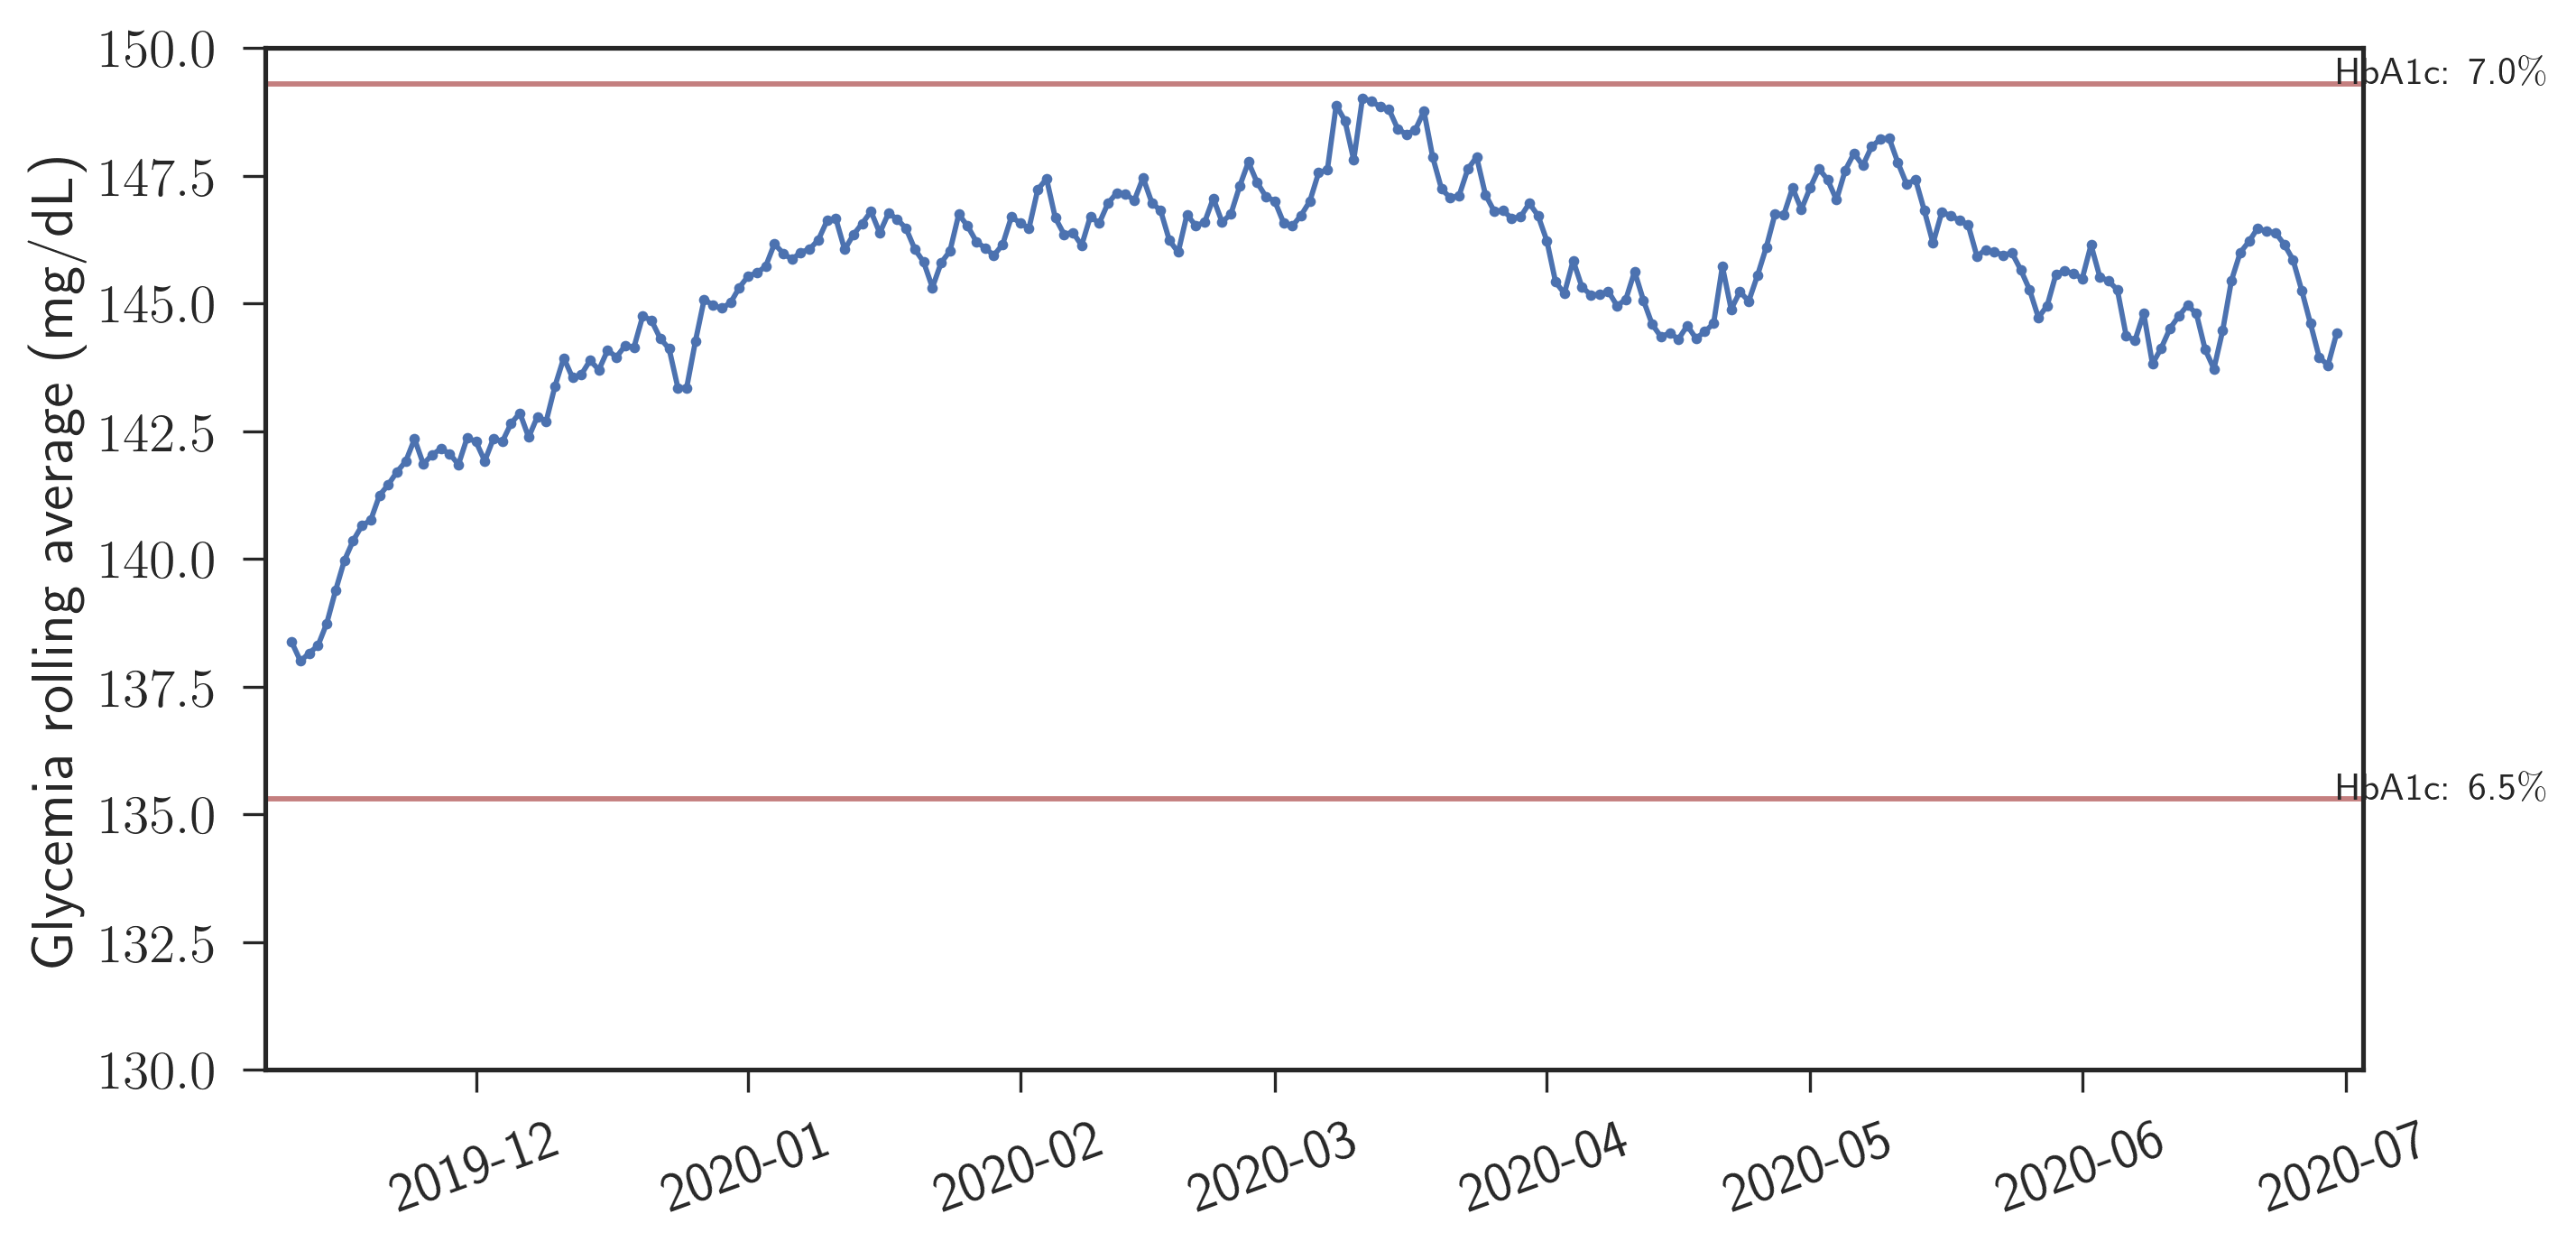

In [5]:
def plot_rolling_average_glycemia(df, start_date, end_date, window_size):

    df = df[start_date:end_date]
    df = df['glucose'].groupby(df.index.date).mean()
    df = df.rolling(window=window_size).mean().dropna()

    hba1c = np.arange(5, 13, 0.5)
    avg = 28 * hba1c - 46.7
    hb_avg = pd.DataFrame(np.transpose([hba1c, avg]),
                          columns=['hba1c', 'average'])
    mini, maxi = np.floor(min(df)/10)*10, np.floor(1+max(df)/10)*10

    hb_avg = hb_avg[(hb_avg['average']>mini) & (hb_avg['average']<maxi)]
    hb_avg = np.transpose(hb_avg.values)


    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

    sns.set_style('darkgrid')
    
    plt.plot(df, marker='.')
    ax.set_xlim(df.index[0]-timedelta(days=3), df.index[-1]+timedelta(days=3))
    ax.set_ylim(mini, maxi)

    if np.size(hb_avg[0])>0:
        for i in range(np.size(hb_avg[0])):
            ax.axhline(hb_avg[1][i], color='darkred', alpha=0.5)
            plt.text(df.index[-1], hb_avg[1][i],
                     'HbA1c: %s'%hb_avg[0][i]+r'$\%$', size=10)
            

    ax.set_ylabel('Glycemia rolling average (mg/dL)')

    plt.xticks(rotation=20)

plot_rolling_average_glycemia(df, start_date, end_date, 
                                  option_dict[option][2])


**The following graph exhibits the glycemia daily average as a function of the glycemia daily standard deviation. The line is a representation of the function: avg = 2 * std which is a common rule of thumb to assess whether the glucose variability is high. The kde plots enable to derive easily the  median daily average (and the distribution) and the median standard deviation (and the distribution) for further analysis**

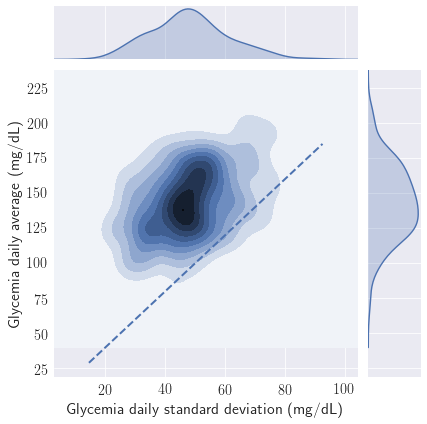

In [6]:
def plot_glucose_stability(df, start_date, end_date):
    
    df = df[start_date:end_date]
    mean = pd.DataFrame(df['glucose'].groupby(df.index.date).mean())
    std = pd.DataFrame(df['glucose'].groupby(df.index.date).std())
    
    mean_col_name = 'Glycemia daily average (mg/dL)'
    std_col_name = 'Glycemia daily standard deviation (mg/dL)'
    
    std.rename(columns={'glucose':std_col_name}, inplace=True)

    df = pd.concat([mean,std],axis=1).dropna()
    df.rename(columns={'glucose':mean_col_name}, inplace=True)

    min_std, max_std = np.min(df[std_col_name]), np.max(df[std_col_name])
            
    var_plot = sns.jointplot(data=df, x=std_col_name, y=mean_col_name, kind='kde')

    var_plot.ax_joint.plot([min_std,max_std], [2*min_std,2*max_std],\
                       color='b', linewidth=2, linestyle='--')
    var_plot.ax_joint.legend_.remove()

plot_glucose_stability(df, start_date, end_date)